In [0]:
!pip install --upgrade -q gspread
from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())

KeyboardInterrupt: ignored

In [0]:
!pip install tensorflow==2.0.0b1

     |████████████████████████████████| 87.9MB 44kB/s 
     |████████████████████████████████| 3.1MB 42.9MB/s 
     |████████████████████████████████| 501kB 57.1MB/s 
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled tensorflow-1.15.0


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from tensorflow import keras

In [0]:
data = pd.read_csv ('https://docs.google.com/spreadsheets/d/e/2PACX-1vRuGqflRrfrBg5vQH0OGfsxjCx55uihMjjO22JGvpN9gK0FQwz_qsaOV5IUYsVZ3DCBcRKcNYPvLL7w/pub?gid=11731492&single=true&output=csv')

In [0]:
data['OPEN'] = (pd.to_numeric(data['OPEN'],downcast='float') / 10000000)
data['HIGH'] = (pd.to_numeric(data['HIGH'],downcast='float') / 10000000)
data['LOW'] = (pd.to_numeric(data['LOW'],downcast='float')   / 10000000)
data['CLOSE'] = (pd.to_numeric(data['CLOSE'],downcast='float')   / 10000000)
data['VOL'] = pd.to_numeric(data['VOL'],downcast='integer')

In [0]:
import math

# Turning the data into daily figures
dailyValues = np.zeros((1,10))
current_date = data["DATE"][0] #can be deleted?
volumeCount = data["VOL"][0]  #can be deleted?

weightedOpen = data["OPEN"][0]
weightedClose = data["CLOSE"][0]
weightedLow = data["LOW"][0]
weightedHigh = data["HIGH"][0]
dailyOpen = data["OPEN"][0]
dailyClose = 0.0
dailyLow = data["LOW"][0]
dailyHigh = data["HIGH"][0]

# volume weighted average function
def WeightedAverage(volumeCount,volume, weightedValue, value):
  weightedAverage = (volumeCount/(volumeCount+volume)) * weightedValue + (volume/(volumeCount+volume)) * value
  return weightedAverage

# for loop over all the 15 min data.
for i in range(1,121093):
  if (data['DATE'][i] == current_date): # if the 15 min interval pertains to the data that is presently under consideration.
    # add the data of the row to the current values for the current date

    tempVolume = data["VOL"][i]    
    weightedOpen = WeightedAverage(volumeCount,tempVolume,weightedOpen,data["OPEN"][i])
    weightedClose = WeightedAverage(volumeCount,tempVolume,weightedClose,data["CLOSE"][i])
    weightedLow = WeightedAverage(volumeCount,tempVolume,weightedLow,data["LOW"][i])
    weightedHigh = WeightedAverage(volumeCount,tempVolume,weightedHigh,data["HIGH"][i])

    # Check whether daily high / low value was achieved in this 15 min period 
    if(data['LOW'][i] < dailyLow):
      dailyLow = data['LOW'][i]
    if(data['HIGH'][i] > dailyHigh):
      dailyHigh = data['HIGH'][i]

    # update the volume last for computation reasons  
    volumeCount += data['VOL'][i]

  else: # if a new day has begun.
    # 1. finalize the computation of daily averages by adding the computed values to the array
    dailyClose = data["CLOSE"][i-1] # fix the final closing value of the day

    current = np.array([current_date,volumeCount,weightedOpen,weightedClose, weightedLow, weightedHigh, dailyOpen,dailyClose, dailyLow, dailyHigh], ndmin=2)
    dailyValues = np.append(dailyValues, current,axis = 0)

    # 2. initialize a new day by setting current_date to the new date that is started
    current_date = data["DATE"][i]
    
    weightedOpen = data["OPEN"][i]
    weightedClose = data["CLOSE"][i]
    weightedLow = data["LOW"][i]
    weightedHigh = data["HIGH"][i]
    dailyOpen = data["OPEN"][i]
    dailyClose = 0.0
    dailyLow = data["LOW"][i]
    dailyHigh = data["HIGH"][i]

    volumeCount = data['VOL'][i]

daily_Dataframe = pd.DataFrame(dailyValues, columns=['Date', 'Vol','weightedOpen','weightedClose', 'weightedLow', 'weightedHigh', 'dailyOpen','dailyClose', 'dailyLow', 'dailyHigh'])
daily_Dataframe.drop(daily_Dataframe.index[0])

Date        Vol  weightedOpen  ...  dailyClose    dailyLow   dailyHigh
1     20150101.0    19042.0  1.209848e+07  ...  12101500.0  12091800.0  12104000.0
2     20150102.0   904944.0  1.204048e+07  ...  12003500.0  12000000.0  12107500.0
3     20150103.0    32964.0  1.200259e+07  ...  11996500.0  11992500.0  12006300.0
4     20150104.0     4595.0  1.200103e+07  ...  11997500.0  11995300.0  12005100.0
5     20150105.0  1456843.0  1.193547e+07  ...  11942900.0  11865000.0  12003600.0
...          ...        ...           ...  ...         ...         ...         ...
1714  20190925.0  1974175.0  1.097988e+07  ...  10952300.0  10936000.0  11017000.0
1715  20190926.0  1936900.0  1.094171e+07  ...  10920000.0  10907900.0  10967400.0
1716  20190927.0  1770107.0  1.093059e+07  ...  10939400.0  10903800.0  10958700.0
1717  20190929.0    50165.0  1.094294e+07  ...  10941700.0  10937500.0  10946300.0
1718  20190930.0  1797132.0  1.091524e+07  ...  10898000.0  10883900.0  10947800.0

[1718 rows x 10 columns]

Dateformat day/month/year

In [0]:
forex = daily_Dataframe.copy()

for i in range(1, 1718): #disregarding first row
    date1 = str(daily_Dataframe['Date'][i])
    y = date1[0:4]
    m = date1[4:6]
    d = date1[6:8]
    forex['Date'][i] = d + m + y
    forex['Date'][i] =  pd.to_datetime(forex['Date'][i], format='%d%m%Y') #how to get rid of time?

forex

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Date        Vol  ...    dailyLow   dailyHigh
0                       0        0.0  ...         0.0         0.0
1     2015-01-10 00:00:00    19042.0  ...  12091800.0  12104000.0
2     2015-01-02 00:00:00   904944.0  ...  12000000.0  12107500.0
3     2015-01-03 00:00:00    32964.0  ...  11992500.0  12006300.0
4     2015-01-04 00:00:00     4595.0  ...  11995300.0  12005100.0
...                   ...        ...  ...         ...         ...
1714  2019-09-25 00:00:00  1974175.0  ...  10936000.0  11017000.0
1715  2019-09-26 00:00:00  1936900.0  ...  10907900.0  10967400.0
1716  2019-09-27 00:00:00  1770107.0  ...  10903800.0  10958700.0
1717  2019-09-29 00:00:00    50165.0  ...  10937500.0  10946300.0
1718          2.01909e+07  1797132.0  ...  10883900.0  10947800.0

[1719 rows x 10 columns]

In [0]:
from fbprophet import Prophet
import logging

logging.getLogger().setLevel(logging.ERROR)

In [0]:
df = forex.reset_index()
df = df[:-1]
df = df[1:]

#Prophet requires the date column to be named ds 
#and the feature column to be named y
df.rename(columns={'Date':'ds',
                          'dailyClose':'y'}, 
                 inplace=True)
df = df[['ds', 'y']]
df
prediction_size = 30
train_df = df[:-prediction_size]
m = Prophet()
m.fit(train_df)

In [0]:
future = m.make_future_dataframe(periods=prediction_size)

forecast = m.predict(future)

In [0]:
forecast.head()


ds         trend  ...  multiplicative_terms_upper          yhat
0 2015-01-02  1.184711e+07  ...                         0.0  1.180188e+07
1 2015-01-03  1.183212e+07  ...                         0.0  1.179507e+07
2 2015-01-04  1.181713e+07  ...                         0.0  1.178043e+07
3 2015-01-05  1.180214e+07  ...                         0.0  1.177741e+07
4 2015-01-06  1.178714e+07  ...                         0.0  1.176355e+07

[5 rows x 19 columns]

In [0]:
m.plot(forecast)

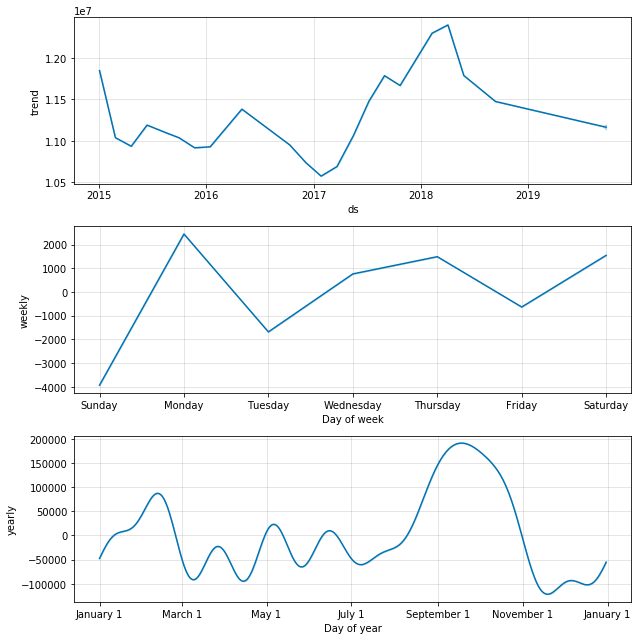

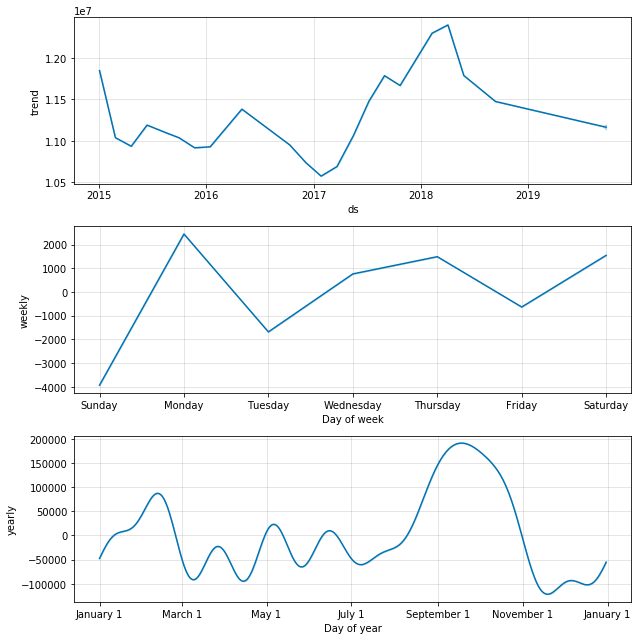

In [0]:
# if the time series has any interesting features, such as seasonality
# there is no clear trend
m.plot_components(forecast)

In [0]:
def make_comparison_dataframe(historical, forecast):
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))

In [0]:
cmp_df = make_comparison_dataframe(df, forecast)

cmp_df.head()

yhat    yhat_lower    yhat_upper           y
ds                                                              
2015-01-02  1.180188e+07  1.166623e+07  1.194747e+07  12003500.0
2015-01-03  1.179507e+07  1.164875e+07  1.194125e+07  11996500.0
2015-01-04  1.178043e+07  1.164444e+07  1.192830e+07  11997500.0
2015-01-05  1.177741e+07  1.164451e+07  1.190955e+07  11942900.0
2015-01-06  1.176355e+07  1.161199e+07  1.190482e+07  11895200.0

In [0]:
def calculate_forecast_errors(df, prediction_size):
    
    df = df.copy()
    
    df['e'] = df['y'] - df['yhat']
    df['p'] = 100 * df['e'] / df['y']
    
    predicted_part = df[-prediction_size:]
    
    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))
    
    return {'MAPE': error_mean('p'), 'MAE': error_mean('e')}

In [0]:
for err_name, err_value in calculate_forecast_errors(cmp_df, prediction_size).items():
    print(err_name, err_value)

MAPE 2.797617390223951
MAE 308540.8651322552


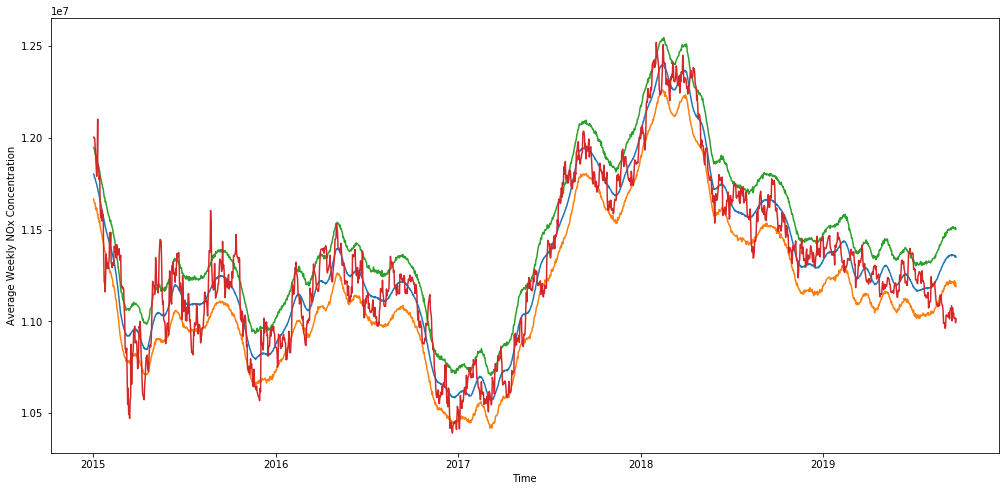

In [0]:
plt.figure(figsize=(17, 8))
plt.plot(cmp_df['yhat'])
plt.plot(cmp_df['yhat_lower'])
plt.plot(cmp_df['yhat_upper'])
plt.plot(cmp_df['y'])
plt.xlabel('Time')
plt.ylabel('Average Weekly NOx Concentration')
plt.grid(False)
plt.show()